In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl 
from matplotlib.ticker import MultipleLocator

In [2]:
#dist_numpy = np.load('./ic_chan2_1_combined_all_feb21cpu_plotfeb28_numpy_posterior.npy')
dist_numpy = np.load('/global/cscratch1/sd/wbhimji/etalumis_data_dec7_2018/plots/ic_posteriors-parallel-combined/Aug5_masterwithprior_chan2_0-combine_resampled_5000-numpy.npy')
#dist_numpy = np.load('/global/cscratch1/sd/wbhimji/etalumis_data_dec7_2018/plots/ic_posteriors-parallel-combined/Apr12_hpo_lstm_dim_512_lstm_depth_1_proposal_mixture_components_5-OLDBESTCHAN2-numpy_posterior.npy')
rmh_numpy = np.load('./rmh_prior_chan_2-numpy.npy')
ground = np.load('./gt_chan2_1.npy')

In [3]:
num_traces =  dist_numpy.shape[0]
num_traces_rmh =  rmh_numpy.shape[0]

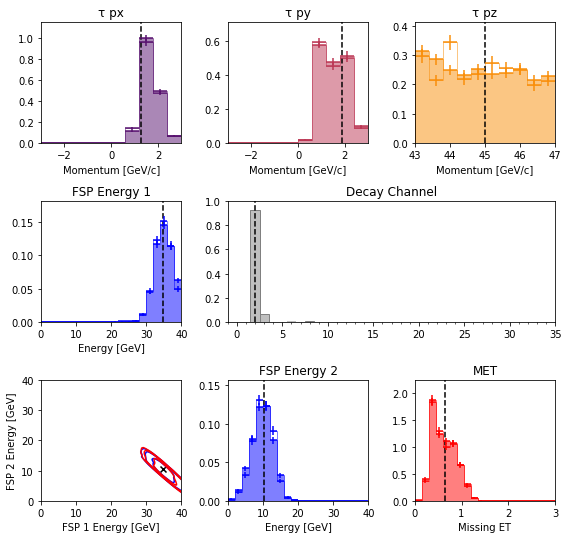

In [6]:
ground_truth_trace='/global/cscratch1/sd/wbhimji/etalumis_data_dec7_2018/plots/gt_chan2_1.npy'

mother           = dist_numpy[:,:3]
mother_rmh       = rmh_numpy[:,:3]
channel          = dist_numpy[:,3]
channel_rmh      = rmh_numpy[:,3]
final            = dist_numpy[:,4:4+(30*8)].reshape(num_traces,30,8)
final_rmh            = rmh_numpy[:,4:4+(30*8)].reshape(num_traces_rmh,30,8)
finalfilt        = [np.array(sorted(f[f>-9999].reshape(-1,8), key=lambda x: -x[3])) for f in final]
finalfilt_rmh        = [np.array(sorted(f[f>-9999].reshape(-1,8), key=lambda x: -x[3])) for f in final_rmh]
finalmult        = np.array([f.shape[0] for f in finalfilt])
obs              = dist_numpy[:,4+(30*8):].reshape(num_traces,35,35,20)
#particle_types   = np.array([nhad_nem_ninvis(f[:,6],f[:,7]) for f in finalfilt])
if ground is not None:
            g_mother         = ground[:3]
            g_channel        = ground[3]
            g_final          = ground[4:4+(30*8)].reshape(30,8)
            g_finalfilt      = np.array(sorted(g_final[g_final>-9999].reshape(-1,8), key=lambda x: -x[3]))
            g_finalmult      = g_finalfilt.shape[0]
            g_obs            = ground[4+(30*8):].reshape(35,35,20)
#            g_particle_types = nhad_nem_ninvis(g_finalfilt[:,6],g_finalfilt[:,7])
f = plt.figure()
f.set_size_inches(8,8)
shape = (3,3)

ax1 = plt.subplot2grid(shape, (0, 0))
ax2 = plt.subplot2grid(shape, (0, 1))
ax3 = plt.subplot2grid(shape, (0, 2))

motheraxes = [ax1,ax2,ax3]
channelax   = plt.subplot2grid(shape, (1, 1), colspan=2)        
        # ## tau momentum
axarr = motheraxes
colors = mpl.cm.inferno(np.linspace(0,1,5))[1:-1]

titles = ['τ px','τ py','τ pz']
limits = [[-3,3],[-3,3],[43,47]]

energies = np.array([f[:2] for f in finalfilt])
energies_rmh = np.array([f[:2] for f in finalfilt_rmh])

def make_met(fin):
    x = []
    for e in fin:
        filtered = e[e[:,-1]>-9999]
        mom = np.sum([f for f in filtered if not f[-1]], axis=0)
        met = np.sqrt(mom[0]**2 + mom[1]**2)
        x.append(met)
    return np.asarray(x)


def observable_set(ax,title,datasets,ground_truth, bins, color, xlabel):
#    integrals = [570.33, 2000]
#Below is remade for camera read SC paper
    integrals = [1379.73,2000]
    counts_list = [np.histogram(d, bins = bins)[0] for d in datasets]
    counts_list = [c/np.sum(c)*intg for intg,c in zip(integrals,counts_list)]

    binwidth = (bins[1:]-bins[:-1])[0]
    centers  = bins[:-1]+(bins[1:]-bins[:-1])/2.
    errs_heights = [(np.sqrt(c)/np.sum(c)/binwidth, c/np.sum(c)/binwidth) for c in (counts_list)]

    h1,_,_ = ax.hist(datasets[0], bins = bins, facecolor = color, edgecolor = color, density=True, fill=False, alpha = 0.5, histtype='step')
    h2,_,_ = ax.hist(datasets[1], bins = bins, facecolor = color, edgecolor = color, density=True, fill=True, alpha = 0.5, histtype='step')

    maxy = 1.2*np.max(h1)
    
    l = ax.vlines(ground_truth,0,10, linestyles='dashed')
    ax.set_ylim(0,maxy)
    ax.set_xlim(min(bins),max(bins))
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    for err,hei in errs_heights:
        ax.bar(centers, hei, yerr = err, width = binwidth, linewidth = 0, fill = None, alpha = 0.2, ecolor = color, xerr = binwidth/2.)
#     ax.bar(centers, [h for h,_ in errs_heights])

met = make_met(final)
met_rmh = make_met(final_rmh)

for i in [0,1,2]:
    axarr[i].clear()
    observable_set(axarr[i],
        title = titles[i],
        ground_truth = g_mother[i],
        color = colors[i],
        datasets = [
        mother[:,i],
        mother_rmh[:,i]
    ], bins = np.linspace(limits[i][0],limits[i][1],11), xlabel = 'Momentum [GeV/c]')


ax4 = plt.subplot2grid(shape, (1, 0))
observable_set(ax4,
    title = 'FSP Energy {}'.format(0 + 1),
    ground_truth = g_finalfilt[:3][0,3],
    color = 'blue',
    datasets = [
    energies[:,0,3],
    energies_rmh[:,0,3]
], bins = np.linspace(0,40,21), xlabel = 'Energy [GeV]')


ax5 = plt.subplot2grid(shape, (2, 1))
observable_set(ax5,
    title = 'FSP Energy {}'.format(1 + 1),
    ground_truth = g_finalfilt[:3][1,3],
    color = 'blue',
    datasets = [
    energies[:,1,3],
    energies_rmh[:,1,3]
], bins = np.linspace(0,40,21), xlabel = 'Energy [GeV]')

ax = channelax
ch = ax.hist(channel, np.linspace(-0.5,35.5,37), density=True, fill=False, facecolor = 'grey',edgecolor='grey')
ch = ax.hist(channel_rmh, np.linspace(-0.5,35.5,37), density=True, facecolor = 'grey',alpha=0.5)
if ground_truth_trace is not None:
    l = ax.vlines(g_channel,0,1.0, linestyles='dashed')
ax.set_ylim(0.,1.0)
ax.set_xlim(-1, 35)
# ax.legend([l,ch[2][0]],['ground truth','posterior'])
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.set_title('Decay Channel')


ax_ctr = plt.subplot2grid(shape, (2, 0))
draw_contour(ax_ctr, datasets = [energies[:,0,3],energies[:,1,3]], color = 'blue', style = 'solid')
draw_contour(ax_ctr, datasets = [energies_rmh[:,0,3],energies_rmh[:,1,3]], color = 'r', style = 'solid')
plt.scatter([g_finalfilt[:3][0,3]],[g_finalfilt[:3][1,3]], marker = 'x', c = 'k')
ax_ctr.set_xlim(0,40)
ax_ctr.set_ylim(0,40)
ax_ctr.set_ylabel('FSP 2 Energy [GeV]')
ax_ctr.set_xlabel('FSP 1 Energy [GeV]')
plt.tight_layout(rect=[0, 0.03, 1, 0.98])




ax_met = plt.subplot2grid(shape, (2, 2))

neutr_truth = g_finalfilt[g_finalfilt[:,-1]==0][0]
met_truth = np.sqrt(neutr_truth[0]**2 + neutr_truth[1]**2)

observable_set(ax_met,
    title = 'MET',
    ground_truth = met_truth,
    color = 'red',
    datasets = [
    met,
    met_rmh
], bins = np.linspace(0,3,21), xlabel = 'Missing ET')


f.savefig('eta_physics_chan2_Aug29_2019_resampled-2.pdf')

In [8]:
!open eta_physics_chan11.pdf

/usr/bin/sh: open: command not found


NameError: name 'xmin' is not defined

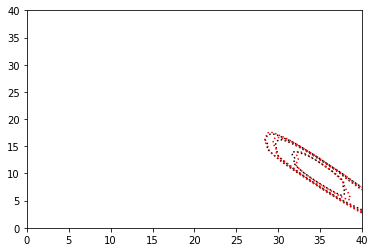

In [5]:
import matplotlib.pyplot as pl
import scipy.stats as st


def draw_contour(ax,datasets,color, style = 'dotted'):
    x = datasets[0]
    y = datasets[1]
    xmin, xmax = 0,40
    ymin, ymax = 0,40
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])
    kernel = st.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    cset = ax.contour(xx, yy, f, colors=color, levels = [2e-3,5e-3,2e-2], linestyles = style, alpha = 1.0)
    

fig = pl.figure()
ax = fig.gca()
draw_contour(ax, datasets = [energies[:,0,3],energies[:,1,3]], color = 'k')
draw_contour(ax, datasets = [energies_rmh[:,0,3],energies_rmh[:,1,3]], color = 'r')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel('Y1')
ax.set_ylabel('Y0')

In [ ]:
plt.bar(np.arange(len(c)),c, yerr = np.sqrt(c)/np.sum(c)*500.)

In [ ]:
plt.hist(mother[:,3], bins = np.linspace(0,5,11))
plt.hist(mother_rmh[:,3], bins = np.linspace(0,5,11), alpha = 0.2)

In [ ]:

# plt.hist(energies[:,0,-1])

In [ ]:
# for event in final:
#     print(event)

In [ ]:
plt.hist(met, bins = np.linspace(0,20,11), alpha = 0.2)
plt.hist(met_rmh, bins = np.linspace(0,20,11), alpha = 0.2)
plt.savefig('ok.pdf')

In [ ]:
!open ok.pdf

In [ ]:
met_truth